# **Dependencies**



In [ ]:
!pip install mygene
!pip install gseapy
!pip install networkx
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import mygene
import gseapy as gp
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from scipy.integrate import solve_ivp
import os
import subprocess
import gzip
import requests
import networkx as nx
from io import StringIO
from sklearn.decomposition import PCA

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.2/549.2 kB 6.8 MB/s eta 0:00:00


# **Load, Inspect, and Prepare Data**

### **Downloading Data**

In [ ]:
def download_and_load_data(url, output_filename, sep="\t", column_filter=None):
    # Download the file using wget
    print(f"Downloading {output_filename} from {url}...")
    subprocess.run(["wget", "-O", output_filename + ".gz", url], check=True)

    # Unzip file using gunzip
    print(f"Unzipping {output_filename}.gz...")
    with gzip.open(output_filename + ".gz", "rb") as gz_file:
        with open(output_filename, "wb") as out_file:
            out_file.write(gz_file.read())

    # Load the data into a Pandas dataframe
    print(f"Loading {output_filename} into a pandas DataFrame...")
    df = pd.read_csv(output_filename, sep=sep, index_col=0)

    # Optionally,  filter columns based on keyword
    if column_filter:
        print(f"Filtering columns with keyword '{column_filter}'...")
        filtered_columns = [col for col in df.columns if column_filter in col]
        df = df[filtered_columns]

    # Return pandas data frame
    return df

In [ ]:
# Example usage
''' Uncomment for use
count_matrix = download_and_load_data(url= "Your URL Here",
                                   output_filename= "Output filename here",
                                   column_filter= "Optional column filter")

count_matrix.head()
'''

CalledProcessError: Command '['wget', '-O', 'Output filename here.gz', 'Your URL Here']' returned non-zero exit status 4.

In [ ]:
# check for missing values
print(count_matrix.isnull().sum())

'\nprint(count_matrix.isnull().sum())\n'

### **Converting Ensemble IDs to Gene Names**

In [ ]:
def convert_ensembl_to_gene_symbols(count_matrix, species='human'):
    try:
        # Create a copy to avoid modifying the original
        count_matrix = count_matrix.copy()

        # Remove version numbers from Ensembl IDs
        cleaned_index = count_matrix.index.str.split('.').str[0]
        count_matrix.index = cleaned_index

        # Initialize MyGeneInfo object and query gene symbols
        mg = mygene.MyGeneInfo()
        ensembl_ids = count_matrix.index.unique().tolist()

        # Query gene information with error handling
        gene_info = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species=species, verbose=False)

        # Convert to DataFrame and clean results
        gene_df = pd.DataFrame(gene_info)
        gene_df = gene_df.dropna(subset=['symbol'])
        gene_df = gene_df.drop_duplicates(subset='query')

        # Map gene symbols to count matrix
        symbol_map = gene_df.set_index('query')['symbol']
        count_matrix['Gene_Name'] = count_matrix.index.map(symbol_map)

        # Reorganize columns with Gene_Name first
        cols = ['Gene_Name'] + [col for col in count_matrix.columns if col != 'Gene_Name']
        count_matrix = count_matrix[cols]

        # Log conversion statistics
        total_genes = len(ensembl_ids)
        mapped_genes = len(gene_df)
        print(f"Successfully mapped {mapped_genes} out of {total_genes} genes ({mapped_genes/total_genes*100:.1f}%)")

        return count_matrix

    except Exception as e:
        raise Exception(f"Error during gene ID conversion: {str(e)}")

In [ ]:
# Example usage

count_matrix_gene_names = convert_ensembl_to_gene_symbols(count_matrix, species='human')
count_matrix_gene_names.head()


Successfully mapped 19879 out of 23044 genes (86.3%)


,Gene_Name,JJ_AMIL_141050_INTER-Str_counts,JJ_AMIL_141056_INTER-Str_counts,JJ_AMIL_141062_INTER-Str_counts,JJ_CTRL_141048_INTER-Str_counts,JJ_CTRL_141054_INTER-Str_counts,JJ_CTRL_141060_INTER-Str_counts
ENSG00000000419,DPM1,1520.00,2420.00,2820.00,1880.00,1610.00,1760.00
ENSG00000000457,SCYL3,675.00,765.00,772.00,777.00,744.00,795.00
ENSG00000000460,FIRRM,1110.00,1060.00,855.00,999.00,906.00,791.00
ENSG00000000938,FGR,3.96,2.41,3.68,1.13,3.43,1.28
ENSG00000000971,CFH,3000.00,2570.00,2810.00,2820.00,2450.00,2560.00


In [ ]:
# Download CSV
from google.colab import files
count_matrix_gene_names.to_csv('count_matrix_gene_names.csv')
files.download('count_matrix_gene_names.csv')

### **Exploratory Data Analysis**

In [ ]:
def visualize_rnaseq_qc(count_matrix, figure_size=(15, 12)):
    # Drop the Gene Name column for counting
    countlist_no_name = count_matrix.iloc[:, 1:]

    # Calculate total counts and log transform
    total_counts = countlist_no_name.sum(axis=0)
    log_counts = countlist_no_name.apply(lambda x: np.log2(x + 1))

    # Create main visualization figure
    fig1, axes = plt.subplots(2, 2, figsize=figure_size)

    # Panel 1: Total counts per sample
    sns.barplot(x=countlist_no_name.columns, y=total_counts, color='skyblue', ax=axes[0,0])
    axes[0,0].set_ylabel('Total Counts')
    axes[0,0].set_title('Total Counts per Sample')
    axes[0,0].tick_params(axis='x', rotation=85)

    # Panel 2: Log transformed counts distribution
    log_counts.boxplot(ax=axes[0,1])
    axes[0,1].set_ylabel('Log2(Counts + 1)')
    axes[0,1].set_title('Log Transformed Counts per Sample')
    axes[0,1].tick_params(axis='x', rotation=85)

    # Panel 3: Sample correlation heatmap
    correlation_matrix = log_counts.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0.5, vmin=0, vmax=1, ax=axes[1,0])
    axes[1,0].set_title('Sample Correlation Matrix')

    # Panel 4: PCA plot
    pca = PCA(n_components=2)
    scaler = StandardScaler()
    pca_result = pca.fit_transform(scaler.fit_transform(log_counts.T))
    pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'], index=log_counts.columns)
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', s=100, ax=axes[1,1])
    for idx, row in pca_df.iterrows():
        axes[1,1].annotate(idx, (row['PC1'], row['PC2']))
    axes[1,1].set_title(f'PCA Plot\nPC1 ({pca.explained_variance_ratio_[0]:.1%}) vs PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    plt.tight_layout()

    # Create dendrogram figure
    fig2 = plt.figure(figsize=(8, 6))
    h_clustering = linkage(log_counts.T, 'ward')
    dendrogram(h_clustering, labels=countlist_no_name.columns)
    plt.xticks(rotation=90)
    plt.ylabel('Distance')
    plt.title('Sample Clustering Dendrogram')

    # Generate QC metrics
    qc_stats = {
        'total_reads': total_counts.sum(),
        'mean_reads_per_sample': total_counts.mean(),
        'cv_reads': total_counts.std() / total_counts.mean(),
        'min_sample_correlation': correlation_matrix.min().min(),
        'max_sample_correlation': correlation_matrix.max().min(),
        'pc1_variance': pca.explained_variance_ratio_[0],
        'pc2_variance': pca.explained_variance_ratio_[1]}
    print("\nRNA-seq Quality Control Metrics:")
    print(f"Total sequencing depth: {qc_stats['total_reads']:,.0f}")
    print(f"Mean reads per sample: {qc_stats['mean_reads_per_sample']:,.0f}")
    return fig1, fig2, qc_stats

In [ ]:
# Example usage
'''
main_fig, dendrogram_fig, stats = visualize_rnaseq_qc(count_matrix=count_matrix_gene_names,figure_size=(15, 10))
plt.show()
'''

# **Quality Control, Filtering, and Normalization**


In [ ]:
# plot the number of genes retained as a function of differnet CPM thresholds
def plot_genes_retained_by_cpm(data, min_samples=2):
    # convert raw counts to CPM to normalize the data
    cpm = data.apply(lambda x: (x / x.sum()) * 1e6) #convert raw counts to CPM to normalize
    # define a range of CPM thresholds to test, from 0 to 5 with increments of 0.1
    thresholds = np.arange(0, 5, 0.1)
    # initialize list to store the # of genes retained for ea/ threshold
    genes_retained = []

    # loop through ea/ threshold value to determine the # of genes retained
    for min_cpm in thresholds:
        # create mask where CPM > min_cpm in at least min_samples samples
        mask = (cpm > min_cpm).sum(axis=1) >= min_samples
        # count # of genes that meet the criteria and append to the list
        genes_retained.append(mask.sum())

    # plot # of genes retained as a function of CPM threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, genes_retained, marker='o', color='green')
    plt.axvline(x=1.0, color='red', linestyle='--', label='CPM = 1')
    plt.xlabel('Threshold (CPM)')
    plt.ylabel('Num Genes Retained')
    plt.legend()
    plt.show()

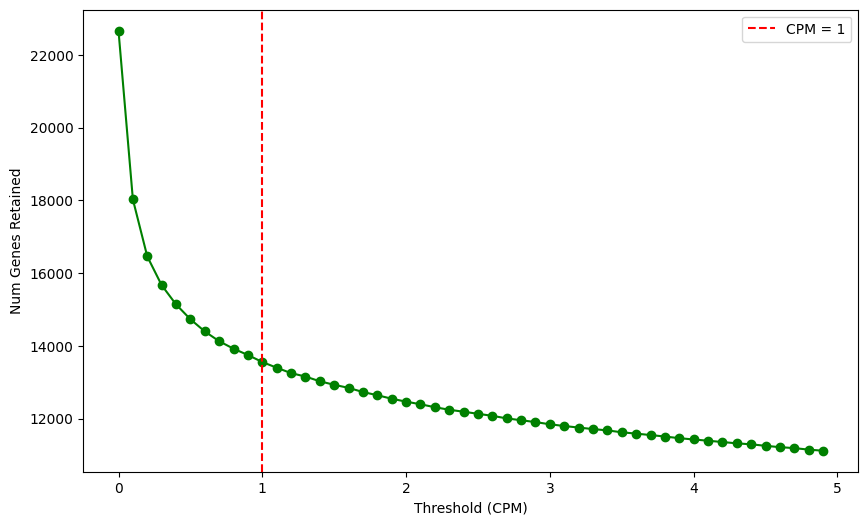

In [ ]:
# Example useage
'''
# Drop the Gene Name column from count_matrix_gene_names for counting
countlist_no_name = count_matrix_gene_names.iloc[:, 1:]

# call plot_genes_retained_by_cpm function
plot_genes_retained_by_cpm(countlist_no_name)
'''

In [ ]:
def filter_normalize(data, min_cpm=1.0, min_samples=2):
    # Extract structural components
    gene_names = data.iloc[:, 0]
    raw_counts = data.iloc[:, 1:]

    # Implement DESeq2-style filtering
    lib_sizes = raw_counts.sum(axis=0)
    cpm = raw_counts.div(lib_sizes, axis=1) * 1e6
    mask = (cpm > min_cpm).sum(axis=1) >= min_samples

    # Apply filtration criteria
    filtered_counts = raw_counts[mask]
    filtered_gene_names = gene_names[mask]

    # Calculate geometric means with DESeq2-inspired approach
    log_counts = np.log(filtered_counts.replace(0, np.nan))
    geometric_means = np.exp(log_counts.mean(axis=1))

    # Estimate size factors using DESeq2 methodology
    size_factor_ratios = filtered_counts.div(geometric_means, axis=0)
    size_factors = size_factor_ratios.median(axis=0)

    # Apply normalization transformation
    normalized_counts = filtered_counts.div(size_factors, axis=1)

    # Reconstruct data architecture
    normalized_data = pd.concat([filtered_gene_names, normalized_counts], axis=1)

    # Generate diagnostic metrics
    diagnostics = {'total_genes_initial': len(data),'genes_post_filtering': len(normalized_data),'size_factors': size_factors.to_dict(),'mean_size_factor': size_factors.mean(),'size_factor_variance': size_factors.var()}

    return normalized_data, diagnostics


In [ ]:
# Example implementation with diagnostic output
'''
filtered_normalized_count_matrix, stats = filter_normalize(count_matrix_gene_names,  min_cpm=1.0, min_samples=2)
print(stats)
'''

{'total_genes_initial': 23044, 'genes_post_filtering': 13557, 'size_factors': {'JJ_AMIL_141050_INTER-Str_counts': 1.0027688405136876, 'JJ_AMIL_141056_INTER-Str_counts': 1.0048870898107296, 'JJ_AMIL_141062_INTER-Str_counts': 1.0011096285714167, 'JJ_CTRL_141048_INTER-Str_counts': 1.0071996800856784, 'JJ_CTRL_141054_INTER-Str_counts': 0.999004128898606, 'JJ_CTRL_141060_INTER-Str_counts': 0.9990038091556457}, 'mean_size_factor': 1.002328862839294, 'size_factor_variance': 1.0811867242898648e-05}


In [ ]:
# Download CSV
from google.colab import files
filtered_normalized_count_matrix.to_csv('filtered_normalized_count_matrix.csv')
files.download('filtered_normalized_count_matrix.csv')

In [ ]:
# Plot the distribution of data after normalization
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Total normalized counts per sample
total_counts_normalized = filtered_normalized_count_matrix.iloc[:, 1:].sum(axis=0)  # Exclude gene_name column
axes[0].bar(filtered_normalized_count_matrix.columns[1:], total_counts_normalized, color='lightcoral')
axes[0].set_ylabel('Total Normalized Counts')
axes[0].set_title('Total Counts per Sample (Normalized)')
axes[0].tick_params(axis='x', rotation=85)

# Log-transformed normalized counts per sample
log_normalized_data = filtered_normalized_count_matrix.iloc[:, 1:].apply(lambda x: np.log2(x + 1), axis=0)  # Exclude gene_name column
log_normalized_data.boxplot(ax=axes[1])
axes[1].set_ylabel('Log2(Normalized Counts + 1)')
axes[1].set_title('Log Transformed Counts per Sample (Normalized)')
axes[1].tick_params(axis='x', rotation=85)

plt.tight_layout()
plt.show()

"\n# Plot the distribution of data after normalization\nfig, axes = plt.subplots(1, 2, figsize=(18, 6))\n\n# Total normalized counts per sample\ntotal_counts_normalized = filtered_normalized_count_matrix.iloc[:, 1:].sum(axis=0)  # Exclude gene_name column\naxes[0].bar(filtered_normalized_count_matrix.columns[1:], total_counts_normalized, color='lightcoral')\naxes[0].set_ylabel('Total Normalized Counts')\naxes[0].set_title('Total Counts per Sample (Normalized)')\naxes[0].tick_params(axis='x', rotation=85)\n\n# Log-transformed normalized counts per sample\nlog_normalized_data = filtered_normalized_count_matrix.iloc[:, 1:].apply(lambda x: np.log2(x + 1), axis=0)  # Exclude gene_name column\nlog_normalized_data.boxplot(ax=axes[1])\naxes[1].set_ylabel('Log2(Normalized Counts + 1)')\naxes[1].set_title('Log Transformed Counts per Sample (Normalized)')\naxes[1].tick_params(axis='x', rotation=85)\n\nplt.tight_layout()\nplt.show()\n"

# **Differential Expression Analysis**

In [45]:
def analyze_differential_expression(expression_matrix, treatment_columns, control_columns,alpha=0.05, lfc_threshold=1.0):
    # Input validation
    if not all(col in expression_matrix.columns for col in treatment_columns + control_columns):
        raise ValueError("Specified columns not found in expression matrix")

    # Initialize results collection
    results = []

    # Perform gene-wise differential expression analysis
    for gene in expression_matrix.index:
        try:
            # Extract and validate group-wise expression values
            treated = pd.to_numeric(expression_matrix.loc[gene, treatment_columns], errors='coerce')
            control = pd.to_numeric(expression_matrix.loc[gene, control_columns], errors='coerce')

            # Remove missing values
            treated = treated.dropna()
            control = control.dropna()

            # Validate sufficient data points
            if treated.empty or control.empty:
                continue

            # Calculate expression statistics
            mean_control = np.mean(control)
            mean_treated = np.mean(treated)

            # Compute fold change with pseudo-count
            log2fc = np.log2((mean_treated + 1) / (mean_control + 1))

            # Perform Welch's t-test (equal_var=False)
            t_stat, p_val = ttest_ind(treated, control, equal_var=False)

            # Compile gene-wise results
            results.append({
                "gene": gene,
                "Gene_Name": expression_matrix.loc[gene, "Gene_Name"] if "Gene_Name" in expression_matrix.columns else gene,
                "log2fc": log2fc,
                "mean_treated": mean_treated,
                "mean_control": mean_control,
                "t_stat": t_stat,
                "p_val": p_val,
                "var_treated": np.var(treated),
                "var_control": np.var(control)})

        except Exception as e:
            print(f"Warning: Error processing gene {gene}: {str(e)}")
            continue

    # Convert to DataFrame and perform quality control
    results_df = pd.DataFrame(results)
    results_df['p_val'] = pd.to_numeric(results_df['p_val'], errors='coerce')
    results_df = results_df.dropna(subset=['p_val'])

    # Apply multiple testing correction
    results_df['p_adj'] = multipletests(results_df['p_val'], method='fdr_bh')[1]

    # Calculate absolute fold change
    results_df['abs_log2fc'] = results_df['log2fc'].abs()

    # Define significance criteria
    results_df['significant'] = (results_df['p_adj'] < alpha) & \
                               (results_df['abs_log2fc'] > lfc_threshold)

    # Generate summary statistics
    summary_stats = {
        'total_genes': len(results_df),
        'significant_genes': results_df['significant'].sum(),
        'up_regulated': sum((results_df['significant']) & (results_df['log2fc'] > 0)),
        'down_regulated': sum((results_df['significant']) & (results_df['log2fc'] < 0)),
        'mean_variance_ratio': np.mean(results_df['var_treated'] / results_df['var_control'])}

    # Sort by statistical significance
    results_df = results_df.sort_values('p_adj')

    print("\nDifferential Expression Analysis Summary:")
    print(f"Total genes analyzed: {summary_stats['total_genes']}")
    print(f"Significant genes: {summary_stats['significant_genes']}")
    print(f"Up-regulated: {summary_stats['up_regulated']}")
    print(f"Down-regulated: {summary_stats['down_regulated']}")
    print(f"Mean variance ratio (treated/control): {summary_stats['mean_variance_ratio']:.2f}")

    return results_df, summary_stats

In [ ]:
# Example usage...
'''
treatment_samples = [...] # column identifiers for treatment condition samples
control_samples = [...] # column identifiers for control condition samples

welch_results, welch_stats = analyze_differential_expression(
    expression_matrix=filtered_normalized_count_matrix,
    treatment_columns=treatment_samples,
    control_columns=control_samples,
    alpha=0.05,  # default significance threshold
    lfc_threshold=1.0)  # default log2 fold change threshold

# Extract DEGs where 'significant' is True
DEGs = welch_results[welch_results['significant'] == True]
DEGs.head()
'''

In [ ]:
# Download CSV
from google.colab import files
results_df.to_csv('results_df.csv')
files.download('results_df.csv')

In [ ]:
# Download CSV
from google.colab import files
DEGs.to_csv('DEGs.csv')
files.download('DEGs.csv')

In [49]:
def visualize_differential_expression_matrix(results_df, filtered_degs, expression_matrix, treatment_columns, control_columns, p_adj_threshold=0.05, abs_log2fc_threshold=1.0, figure_size=(10, 8)):
    fig, axes = plt.subplots(2, 2, figsize=figure_size)
    scatter_params = {'alpha': 0.8,'edgecolor': None,'palette': 'viridis'}

    # Panel 1: Global Expression Landscape (Volcano Plot)
    sns.scatterplot(data=results_df, x='log2fc', y='p_adj', hue='log2fc',ax=axes[0,0], **scatter_params)
    axes[0,0].axhline(y=p_adj_threshold, color='red', linestyle='--', linewidth=1)
    axes[0,0].axvline(x=abs_log2fc_threshold, color='blue', linestyle='--', linewidth=1)
    axes[0,0].axvline(x=-abs_log2fc_threshold, color='blue', linestyle='--', linewidth=1)
    axes[0,0].set_xlabel('log2 Fold Change')
    axes[0,0].set_ylabel('Adjusted P-value')
    axes[0,0].set_title('Global Expression Landscape')

    # Panel 2: Fold Change Distribution (All Genes)
    sns.histplot(data=results_df, x='abs_log2fc',bins=50, kde=True,ax=axes[0,1])

    # Add vertical line at fold change threshold
    axes[0,1].axvline(x=abs_log2fc_threshold, color='red', linestyle='--', linewidth=1)

    axes[0,1].set_title('Distribution of Absolute log2FC (All Genes)')
    axes[0,1].set_xlabel('Absolute log2 Fold Change')
    axes[0,1].set_ylabel('Gene Frequency')

    # Panel 3: MA Plot
    results_df['mean_expression'] = np.log2((results_df['mean_treated'] + results_df['mean_control'])/2 + 1)

    sns.scatterplot(data=results_df, x='mean_expression', y='log2fc', hue='significant' if 'significant' in results_df.columns else None, ax=axes[1,0], **scatter_params)
    axes[1,0].axhline(y=0, color='red', linestyle='--', linewidth=1)
    axes[1,0].set_title('MA Plot (Mean vs Fold Change)')
    axes[1,0].set_xlabel('Mean Expression (log2)')
    axes[1,0].set_ylabel('log2 Fold Change')

    # Panel 4: Distribution of Adjusted P-values
    sns.histplot(data=results_df,x='p_adj',bins=50, kde=True, ax=axes[1,1])

    # Add vertical line at significance threshold
    axes[1,1].axvline(x=p_adj_threshold, color='red', linestyle='--', linewidth=1)
    axes[1,1].set_title('Distribution of Adjusted P-values')
    axes[1,1].set_xlabel('Adjusted P-value')
    axes[1,1].set_ylabel('Gene Frequency')

    plt.tight_layout()

    # Generate comprehensive analytical metrics
    summary_stats = {
        'total_genes': len(results_df),
        'significant_genes': len(filtered_degs),
        'mean_fold_change_all': results_df['abs_log2fc'].mean(),
        'median_fold_change_all': results_df['abs_log2fc'].median(),
        'max_fold_change': results_df['abs_log2fc'].max(),
        'mean_fold_change_sig': filtered_degs['abs_log2fc'].mean(),
        'median_padj': results_df['p_adj'].median(),
        'genes_below_alpha': sum(results_df['p_adj'] < p_adj_threshold)}

    print("\nComprehensive Expression Analysis Metrics:")
    print(f"Total genes analyzed: {summary_stats['total_genes']}")
    print(f"Significant DEGs identified: {summary_stats['significant_genes']}")
    print(f"Mean absolute log2FC (all genes): {summary_stats['mean_fold_change_all']:.2f}")
    print(f"Mean absolute log2FC (significant): {summary_stats['mean_fold_change_sig']:.2f}")
    print(f"Median adjusted p-value: {summary_stats['median_padj']:.3f}")
    print(f"Genes below significance threshold: {summary_stats['genes_below_alpha']}")
    return fig, summary_stats

In [51]:
# example usage
'''
fig, stats = visualize_differential_expression_matrix(
    results_df=welch_results,          # Complete results from differential expression analysis
    filtered_degs=DEGs,    # Subset of significant DEGs
    expression_matrix=filtered_normalized_count_matrix,
    treatment_columns=treatment_samples,
    control_columns=control_samples)

# Display the plot
plt.show()
'''

'\nfig, stats = visualize_differential_expression_matrix(\n    results_df=welch_results,          # Complete results from differential expression analysis\n    filtered_degs=DEGs,    # Subset of significant DEGs\n    expression_matrix=filtered_normalized_count_matrix,\n    treatment_columns=treatment_samples,\n    control_columns=control_samples)\n\n# Display the plot\nplt.show()\n'

# **Extensions**

## **Gene Co-Expression Network Analysis**

In [40]:
def analyze_gene_coexpression(filtered_normalized_countlist, treatment_pattern, control_pattern, n_genes=None, correlation_threshold=0.7):
    # Subset the data to exclude rows with NaN values in the "Gene_Name" column
    filtered_data = filtered_normalized_countlist.dropna(subset=["Gene_Name"])

    # Subset data for treatment and control
    treatment = filtered_data.filter(regex=treatment_pattern)
    control = filtered_data.filter(regex=control_pattern)

    # Ensure the expression data is numeric
    treatment_data_numeric = treatment.apply(pd.to_numeric, errors='coerce')
    control_numeric = control.apply(pd.to_numeric, errors='coerce')

    # Set Gene_Name as the index
    treatment_data_numeric = treatment_data_numeric.set_index(filtered_data["Gene_Name"])
    control_numeric = control_numeric.set_index(filtered_data["Gene_Name"])

    # Select the top n genes
    treatment_data_numeric = treatment_data_numeric.iloc[:n_genes, :]
    control_numeric = control_numeric.iloc[:n_genes, :]

    # Transpose the expression data
    treatment_transposed = treatment_data_numeric.T
    control_transposed = control_numeric.T

    def calculate_correlation_matrix(expression_data):
        return expression_data.corr(method="spearman")

    # Calculate correlation matrices
    treatment_corr_matrix = calculate_correlation_matrix(treatment_transposed)
    control_corr_matrix = calculate_correlation_matrix(control_transposed)

    def create_network(corr_matrix, threshold):
        G = nx.Graph()
        for i, gene1 in enumerate(corr_matrix.index):
            for j, gene2 in enumerate(corr_matrix.columns):
                if i < j:
                    correlation = corr_matrix.iloc[i, j]
                    if abs(correlation) >= threshold:
                        G.add_edge(gene1, gene2, weight=correlation)
        return G

    # Create networks
    treatment_network = create_network(treatment_corr_matrix, correlation_threshold)
    control_network = create_network(control_corr_matrix, correlation_threshold)

    # Create network visualization with subgraphs
    def plot_networks():
        fig = plt.figure(figsize=(15, 12))
        # Plot full networks
        plt.subplot(2, 2, 1)
        pos_treatment = nx.spring_layout(treatment_network, seed=42)
        nx.draw(treatment_network, pos_treatment, with_labels=False, node_size=20, edge_color="lightblue")
        plt.title(f"{treatment_pattern} Full Network")
        plt.subplot(2, 2, 2)
        pos_control = nx.spring_layout(control_network, seed=42)
        nx.draw(control_network, pos_control, with_labels=False, node_size=20, edge_color="lightgreen")
        plt.title(f"{control_pattern} Full Network")

        # Create and plot subgraphs of top 10 nodes
        def get_top_nodes_subgraph(G, n=10):
            # Get degrees and sort nodes
            degrees = dict(G.degree())
            top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:n]
            top_node_names = [node for node, _ in top_nodes]
            # Create subgraph
            subgraph = G.subgraph(top_node_names)
            return subgraph

        # Treatment subgraph
        treatment_sub = get_top_nodes_subgraph(treatment_network)
        plt.subplot(2, 2, 3)
        pos_treatment_sub = nx.spring_layout(treatment_sub, seed=42)
        nx.draw(treatment_sub, pos_treatment_sub, with_labels=True, node_size=500, edge_color="lightblue", font_size=8, font_weight='bold')
        plt.title(f"Top 10 {treatment_pattern} Genes Subnetwork")

        # Control subgraph
        control_sub = get_top_nodes_subgraph(control_network)
        plt.subplot(2, 2, 4)
        pos_control_sub = nx.spring_layout(control_sub, seed=42)
        nx.draw(control_sub, pos_control_sub, with_labels=True, node_size=500, edge_color="lightgreen", font_size=8, font_weight='bold')
        plt.title(f"Top 10 {control_pattern} Genes Subnetwork")
        plt.tight_layout()
        return fig

    # Analyze hub genes
    treatment_degrees = dict(treatment_network.degree())
    control_degrees = dict(control_network.degree())
    sorted_treatment_genes = sorted(treatment_degrees.items(), key=lambda x: x[1], reverse=True)
    sorted_control_genes = sorted(control_degrees.items(), key=lambda x: x[1], reverse=True)

    # Calculate network metrics
    density_treatment = nx.density(treatment_network)
    density_control = nx.density(control_network)

    # Analyze hub genes overlap
    hub_genes_treatment = set([gene for gene, degree in sorted_treatment_genes[:10]])
    hub_genes_control = set([gene for gene, degree in sorted_control_genes[:10]])
    common_hub_genes = hub_genes_treatment.intersection(hub_genes_control)
    unique_treatment_hub_genes = hub_genes_treatment - hub_genes_control
    unique_control_hub_genes = hub_genes_control - hub_genes_treatment

    # Create distribution plots
    def plot_network_distributions():
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        # Plot 1: Cumulative Degree Distribution
        treatment_degrees_list = sorted([d for n, d in treatment_network.degree()], reverse=True)
        control_degrees_list = sorted([d for n, d in control_network.degree()], reverse=True)
        treatment_cumfreq = np.arange(1, len(treatment_degrees_list) + 1) / len(treatment_degrees_list)
        control_cumfreq = np.arange(1, len(control_degrees_list) + 1) / len(control_degrees_list)
        ax1.plot(treatment_degrees_list, treatment_cumfreq, 'r-', label=f'{treatment_pattern}', linewidth=2)
        ax1.plot(control_degrees_list, control_cumfreq, 'b-', label=f'{control_pattern}', linewidth=2)
        ax1.set_xlabel('Node Degree')
        ax1.set_ylabel('Cumulative Frequency')
        ax1.set_title('Cumulative Degree Distribution')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Add statistics to first plot
        treatment_stats = f'{treatment_pattern}:\nMean degree: {np.mean(treatment_degrees_list):.2f}\nMax degree: {max(treatment_degrees_list)}'
        control_stats = f'{control_pattern}:\nMean degree: {np.mean(control_degrees_list):.2f}\nMax degree: {max(control_degrees_list)}'
        ax1.text(0.02, 0.98, treatment_stats, transform=ax1.transAxes,verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        ax1.text(0.02, 0.78, control_stats, transform=ax1.transAxes,verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Plot 2: Edge Weight Distribution
        treatment_weights = [d['weight'] for (u, v, d) in treatment_network.edges(data=True)]
        control_weights = [d['weight'] for (u, v, d) in control_network.edges(data=True)]
        bins = np.linspace(min(min(treatment_weights, default=0), min(control_weights, default=0)),max(max(treatment_weights, default=1), max(control_weights, default=1)), 20)
        ax2.hist(treatment_weights, bins, alpha=0.5, label=treatment_pattern, color='red')
        ax2.hist(control_weights, bins, alpha=0.5, label=control_pattern, color='blue')
        ax2.set_xlabel('Edge Weight (Correlation Strength)')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Edge Weight Distribution')
        ax2.legend()

        # Add statistics to second plot
        treatment_weight_stats = f'{treatment_pattern}:\nMean weight: {np.mean(treatment_weights):.3f}\nMedian weight: {np.median(treatment_weights):.3f}'
        control_weight_stats = f'{control_pattern}:\nMean weight: {np.mean(control_weights):.3f}\nMedian weight: {np.median(control_weights):.3f}'
        ax2.text(0.02, 0.98, treatment_weight_stats, transform=ax2.transAxes,verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        ax2.text(0.02, 0.78, control_weight_stats, transform=ax2.transAxes,verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        plt.tight_layout()
        return fig

    # Calculate detailed network comparison metrics
    def calculate_network_metrics():
        metrics = {
            'Number of Nodes': lambda g: len(g.nodes()),
            'Number of Edges': lambda g: len(g.edges()),
            'Average Degree': lambda g: sum(dict(g.degree()).values())/len(g),
            'Network Density': lambda g: nx.density(g),
            'Average Clustering': lambda g: nx.average_clustering(g),
            'Average Path Length': lambda g: nx.average_shortest_path_length(g) if nx.is_connected(g) else 'Not connected',
            'Number of Connected Components': lambda g: nx.number_connected_components(g)}

        comparison_results = {}
        for metric_name, metric_func in metrics.items():
            try:
                treatment_value = metric_func(treatment_network)
                control_value = metric_func(control_network)
                comparison_results[metric_name] = {
                    'treatment': treatment_value,
                    'control': control_value}
            except Exception as e:
                comparison_results[metric_name] = {
                    'treatment': f"Error: {str(e)}",
                    'control': f"Error: {str(e)}"}
        return comparison_results

    network_comparison = calculate_network_metrics()

    # Create result dictionary
    results = {'networks': {'treatment': treatment_network,'control': control_network},
        'hub_genes': {'treatment_top10': sorted_treatment_genes[:10],'control_top10': sorted_control_genes[:10],'common': common_hub_genes,'unique_treatment': unique_treatment_hub_genes,'unique_control': unique_control_hub_genes},
        'network_metrics': {'treatment_density': density_treatment,'control_density': density_control,'detailed_comparison': network_comparison},
        'figures': {'networks': plot_networks(),'distributions': plot_network_distributions()}}
    return results

def print_analysis_results(results):
    # Print network comparison metrics
    comparison_metrics = results['network_metrics']['detailed_comparison']
    print("\nDetailed Network Comparison:")
    for metric_name, values in comparison_metrics.items():
        print(f"\n{metric_name}:")
        treatment_value = values['treatment']
        control_value = values['control']
        if isinstance(treatment_value, (int, float)):
            print(f"Treatment: {treatment_value:.3f}")
            print(f"Control: {control_value:.3f}")
        else:
            print(f"Treatment: {treatment_value}")
            print(f"Control: {control_value}")

    # Print hub genes
    print("\nTop 10 Hub Genes:")
    print("\nTreatment hub genes:")
    for gene, degree in results['hub_genes']['treatment_top10']:
        print(f"{gene}: {degree} connections")
    print("\nControl hub genes:")
    for gene, degree in results['hub_genes']['control_top10']:
        print(f"{gene}: {degree} connections")
    print("\nHub Gene Analysis:")
    print(f"Common hub genes between networks: {len(results['hub_genes']['common'])}")
    print("Common genes:", results['hub_genes']['common'])
    print(f"\nUnique to treatment: {len(results['hub_genes']['unique_treatment'])}")
    print("Genes:", results['hub_genes']['unique_treatment'])
    print(f"\nUnique to control: {len(results['hub_genes']['unique_control'])}")
    print("Genes:", results['hub_genes']['unique_control'])

In [41]:
# Example usage
''' #uncomment to use
results = analyze_gene_coexpression(
    filtered_normalized_count_matrix,
    treatment_pattern="AMIL", # Select columns with "AMIL" in their names (use appropriate keyword for your own data)
    control_pattern="CTRL", # Select columns with "CTRL" in their names (use appropriate keyword for your own data)
    n_genes = 100 # of genes to include in analysis
    )

print_analysis_results(results)

# Display figures (
plt.figure()
plt.show(results['figures']['networks'])
plt.figure()
plt.show(results['figures']['distributions'])
'''

'\nresults = analyze_gene_coexpression(\n    filtered_normalized_count_matrix,\n    treatment_pattern="AMIL", # Select columns with "AMIL" in their names (use appropriate keyword for your own data)\n    control_pattern="CTRL", # Select columns with "CTRL" in their names (use appropriate keyword for your own data)\n    n_genes = 100 # of genes to include in analysis\n    )\n\nprint_analysis_results(results)\n\n# Display figures (\nplt.figure()\nplt.show(results[\'figures\'][\'networks\'])\nplt.figure()\nplt.show(results[\'figures\'][\'distributions\'])\n'

## **PPI Network Analysis**

In [57]:
def analyze_ppi_network(gene_list, score_threshold=0.7, species='human'):
    def fetch_string_ppi(genes, species):
        """Fetch PPI data from STRING database"""
        base_url = "https://string-db.org/api/tsv/network"
        genes_str = "\n".join(genes)
        params = {'identifiers': genes_str, 'species': species, 'limit': 1}
        response = requests.post(base_url, data=params)
        if response.status_code == 200:
            return response.text
        else:
            print(f"Failed to fetch data from STRING: {response.status_code}")
            return None

    # Fetch and process PPI data
    ppi_data = fetch_string_ppi(gene_list, species)
    if ppi_data is None:
        raise ValueError("No PPI data retrieved. Check your input or STRING database connection.")

    # Parse data and filter by score
    ppi_df = pd.read_csv(StringIO(ppi_data), sep="\t")
    ppi_df_filtered = ppi_df[ppi_df['score'] > score_threshold]

    # Create network
    G = nx.Graph()
    for _, row in ppi_df_filtered.iterrows():
        G.add_edge(row['preferredName_A'], row['preferredName_B'], weight=row['score'])

    # Calculate network metrics
    network_metrics = {'num_nodes': G.number_of_nodes(),'num_edges': G.number_of_edges(),'density': nx.density(G),'num_components': len(list(nx.connected_components(G)))}

    # Calculate node centralities
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    clustering_coefficients = nx.clustering(G)

    # Get top nodes by different metrics
    top_nodes = {
        'degree': sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10],
        'betweenness': sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10],
        'clustering': sorted(clustering_coefficients.items(), key=lambda x: x[1], reverse=True)[:10]}

    def create_network_figures():
        fig = plt.figure(figsize=(20, 20))
        # Full network (top left)
        plt.subplot(2, 2, 1)
        nx.draw_networkx(G, node_size=50, with_labels=True, font_size=8, width=1, alpha=0.7)
        plt.title('Full PPI Network', pad=20, size=14)

        # Node degree distribution (top right)
        plt.subplot(2, 2, 2)
        degrees = [d for n, d in G.degree()]
        plt.hist(degrees, bins=max(10, max(degrees)), alpha=0.7)
        plt.xlabel('Node Degree')
        plt.ylabel('Frequency')
        plt.title('Node Degree Distribution', pad=20, size=14)

        # Top 20 nodes by degree centrality (bottom left)
        plt.subplot(2, 2, 3)
        top_degree_nodes = [node for node, _ in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:20]]
        subgraph_degree = G.subgraph(top_degree_nodes)
        nx.draw_networkx(subgraph_degree, node_size=500, node_color='skyblue', with_labels=True, font_size=10)
        plt.title("Top 20 Nodes by Degree Centrality", pad=20, size=14)

        # Top 20 nodes by betweenness centrality (bottom right)
        plt.subplot(2, 2, 4)
        top_betweenness_nodes = [node for node, _ in sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:20]]
        subgraph_betweenness = G.subgraph(top_betweenness_nodes)
        nx.draw_networkx(subgraph_betweenness, node_size=500, node_color='lightgreen', with_labels=True, font_size=10)
        plt.title("Top 20 Nodes by Betweenness Centrality", pad=20, size=14)
        plt.tight_layout()
        return fig

    # Create visualization
    figure = create_network_figures()

    # Return results
    results = {'network': G,'metrics': network_metrics,'top_nodes': top_nodes,'figure': figure}
    return results

def print_ppi_results(results):
    # Print network metrics
    print(f"Number of nodes: {results['metrics']['num_nodes']} "
          f"Number of edges: {results['metrics']['num_edges']} "
          f"Network density: {results['metrics']['density']:.3f} "
          f"Number of connected components: {results['metrics']['num_components']}")

    # Print top nodes
    print("\nTop 10 nodes by degree centrality:")
    print([node for node, _ in results['top_nodes']['degree']])
    print("\nTop 10 nodes by betweenness centrality:")
    print([node for node, _ in results['top_nodes']['betweenness']])
    print("\nTop 10 nodes by clustering coefficient:")
    print([node for node, _ in results['top_nodes']['clustering']])

In [63]:
# Example usage:
'''
gene_list = DEGs['gene'].tolist()  # Use the `gene` column (ENSEMBL IDs)
results = analyze_ppi_network(gene_list)
print_ppi_results(results)
plt.figure()
plt.show(results['figure'])
'''

"\ngene_list = DEGs['gene'].tolist()  # Use the `gene` column (ENSEMBL IDs)\nresults = analyze_ppi_network(gene_list)\nprint_ppi_results(results)\nplt.figure()\nplt.show(results['figure'])\n"

## **Functional Enrichment Analysis**

In [85]:
# Define the gene lists for each model (DEGs) here
gene_list = DEGs['Gene_Name'].dropna().astype(str).tolist()

# Perform GO enrichment analysis for Biological Process (BP), Molecular Function (MF), Cellular Components (CC), and pathways
biological_processes = gp.enrichr(gene_list, gene_sets=['GO_Biological_Process_2018'], organism='human')
biological_processes = biological_processes.results
molecular_functions = gp.enrichr(gene_list, gene_sets=['GO_Molecular_Function_2018'], organism='human')
molecular_functions = molecular_functions.results
cellular_components = gp.enrichr(gene_list, gene_sets=['GO_Cellular_Component_2018'], organism='human')
cellular_components = cellular_components.results
pathways = gp.enrichr(gene_list, gene_sets=['KEGG_2016'], organism='human')
pathways = pathways.results

# View results
biological_processes
molecular_functions
cellular_components
pathways

"\ngene_list = DEGs['Gene_Name'].dropna().astype(str).tolist()\n\n# Perform GO enrichment analysis for Biological Process (BP), Molecular Function (MF), Cellular Components (CC), and pathways \nbiological_processes = gp.enrichr(gene_list, gene_sets=['GO_Biological_Process_2018'], organism='human')\nbiological_processes = biological_processes.results\nmolecular_functions = gp.enrichr(gene_list, gene_sets=['GO_Molecular_Function_2018'], organism='human')\nmolecular_functions = molecular_functions.results\ncellular_components = gp.enrichr(gene_list, gene_sets=['GO_Cellular_Component_2018'], organism='human')\ncellular_components = cellular_components.results\npathways = gp.enrichr(gene_list, gene_sets=['KEGG_2016'], organism='human')\npathways = pathways.results\n\n# View results\nbiological_processes\nmolecular_functions\ncellular_components\npathways\n"